# Chapter 12: Income Statement Analysis

This chapter explores the **core financial health indicators** found in a company's income statement. We'll use Python to extract, analyze, and visualize key metrics that reveal a company's profitability, efficiency, and growth potential.

### Roadmap for Exploration:
1. **Data Acquisition**: Retrieve historical income statements via Tiingo API
2. **Data Wrangling**: Clean and reshape raw financial data
3. **Metric Calculation**: Compute key profitability indicators
4. **Visualization**: Create insightful trend charts
5. **Interpretation**: Translate numbers into investment insights

**Data Extraction and Preparation**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tiingo import TiingoClient

# Configure Tiingo API
config = {'session': True, 'api_key': os.getenv('TIINGO_API_KEY', 'YOUR KEY')}
client = TiingoClient(config)

# Define ticker and fetch data
ticker = "AAPL"
data = client.get_fundamentals_statements(ticker, startDate='2021-01-01', endDate='2023-12-31', asReported=True)
fundamentals = pd.DataFrame(data)

In [2]:
def filter_quarterly_data(data):
    """Filter out annual reports (quarter=0) to focus on quarterly trends"""
    return data[data['quarter'] != 0]

fundamentals = filter_quarterly_data(fundamentals)

def extract_statement(data, statement_type):
    """Extract and flatten financial statement data"""
    extracted_data = []
    for _, row in data.iterrows():                           
        if statement_type in row['statementData']:
            statement = row['statementData'][statement_type]
            for item in statement:
                item['date'] = row['date']
                item['ticker'] = ticker
                item['quarter'] = row['quarter']
                item['year'] = row['year']
                extracted_data.append(item)
    return pd.DataFrame(extracted_data)

# Extract and reshape income statement data
income_df = extract_statement(fundamentals, 'incomeStatement')

# Pivot the data for easier analysis:
# - Rows become dates (time series)
# - Columns become financial metrics (revenue, expenses, etc.)
# - Values contain the actual dollar amounts
income_pivot = income_df.pivot(index='date', columns='dataCode', values='value').reset_index()

# Display the transformed data
income_pivot.head()

dataCode,date,consolidatedIncome,costRev,ebit,ebitda,ebt,eps,epsDil,grossProfit,intexp,...,nonControllingInterests,opex,opinc,prefDVDs,revenue,rnd,sga,shareswa,shareswaDil,taxExp
0,2022-04-29,2.501000e+10,5.471900e+10,3.083000e+10,3.356700e+10,3.013900e+10,1.54,1.52,4.255900e+10,6.910000e+08,...,0.0,1.258000e+10,2.997900e+10,0.0,9.727800e+10,6.387000e+09,6.193000e+09,1.627880e+10,1.640332e+10,5.129000e+09
1,2022-07-29,1.944200e+10,4.707400e+10,2.378500e+10,2.659000e+10,2.306600e+10,1.20,1.20,3.588500e+10,7.190000e+08,...,0.0,1.280900e+10,2.307600e+10,0.0,8.295900e+10,6.797000e+09,6.012000e+09,1.616294e+10,1.626220e+10,3.624000e+09
2,2022-10-28,2.072100e+10,5.205100e+10,2.548400e+10,2.834900e+10,2.465700e+10,1.29,1.29,3.809500e+10,8.270000e+08,...,0.0,1.320100e+10,2.489400e+10,0.0,9.014600e+10,6.761000e+09,6.440000e+09,1.603038e+10,1.611846e+10,3.936000e+09
3,2023-02-03,2.999800e+10,6.682200e+10,3.662600e+10,3.954200e+10,3.562300e+10,1.89,1.88,5.033200e+10,1.003000e+09,...,0.0,1.431600e+10,3.601600e+10,0.0,1.171540e+11,7.709000e+09,6.607000e+09,1.589272e+10,1.595572e+10,5.625000e+09
4,2023-05-05,2.416000e+10,5.286000e+10,2.931200e+10,3.221000e+10,2.838200e+10,1.53,1.52,4.197600e+10,9.300000e+08,...,0.0,1.365800e+10,2.831800e+10,0.0,9.483600e+10,7.457000e+09,6.201000e+09,1.578715e+10,1.584705e+10,4.222000e+09


## 12.1 Profit Margins Calculation

In [3]:
# Calculate key profitability ratios
income_pivot['gross_profit_margin'] = income_pivot['grossProfit'] / income_pivot['revenue']
income_pivot['operating_profit_margin'] = income_pivot['opinc'] / income_pivot['revenue']
income_pivot['net_profit_margin'] = income_pivot['netinc'] / income_pivot['revenue']

# Display results with interpretation
margin_df = income_pivot[['date', 'gross_profit_margin', 'operating_profit_margin', 'net_profit_margin']].dropna()
print("Profit Margin Analysis:")
print("- Higher margins generally indicate better pricing power and cost control")
print("- Compare to industry averages for context")
print("- Consistent improvement suggests operational efficiency gains\n")
margin_df

Profit Margin Analysis:
- Higher margins generally indicate better pricing power and cost control
- Compare to industry averages for context
- Consistent improvement suggests operational efficiency gains



dataCode,date,gross_profit_margin,operating_profit_margin,net_profit_margin
0,2022-04-29,0.437499,0.308179,0.257098
1,2022-07-29,0.432563,0.278162,0.234357
2,2022-10-28,0.422592,0.276152,0.229860
3,2023-02-03,0.429623,0.307424,0.256056
4,2023-05-05,0.442617,0.298600,0.254756
5,2023-08-04,0.445163,0.281159,0.243053
6,2023-11-03,0.451708,0.301336,0.256497


## 12.2 Earnings and Growth Metrics

In [4]:
income_pivot['eps'] = income_pivot['netinc'] / income_pivot['shareswa']
eps_df = income_pivot[['date', 'eps']].dropna()

print("EPS Interpretation:")
print("- Rising EPS indicates growing profitability per share")
print("- Compare to analyst expectations and historical trends")
print("- Sustained declines may signal fundamental issues\n")
eps_df

EPS Interpretation:
- Rising EPS indicates growing profitability per share
- Compare to analyst expectations and historical trends
- Sustained declines may signal fundamental issues



dataCode,date,eps
0,2022-04-29,1.536354
1,2022-07-29,1.202875
2,2022-10-28,1.292608
3,2023-02-03,1.887531
4,2023-05-05,1.530358
5,2023-08-04,1.266498
6,2023-11-03,1.471592


In [5]:
income_pivot['revenue_growth'] = income_pivot['revenue'].pct_change()
growth_df = income_pivot[['date', 'revenue_growth']].dropna()

print("Revenue Growth Insights:")
print("- Positive growth indicates business expansion")
print("- Negative growth may require investigation")
growth_df

Revenue Growth Insights:
- Positive growth indicates business expansion
- Negative growth may require investigation


dataCode,date,revenue_growth
1,2022-07-29,-0.147197
2,2022-10-28,0.086633
3,2023-02-03,0.299603
4,2023-05-05,-0.190501
5,2023-08-04,-0.137490
6,2023-11-03,0.094148


## 12.3 Financial Visualization

Margin Analysis Guide:
1. Gross margin shows production efficiency
2. Operating margin reflects core business health
3. Net margin reveals overall profitability
Ideal: Stable or improving margins over time


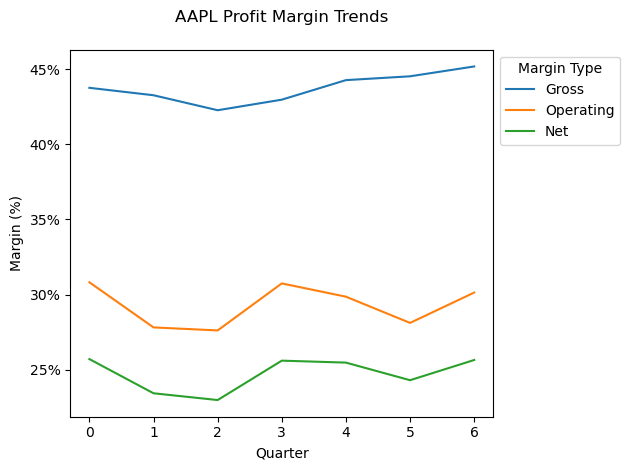

In [6]:
ax = income_pivot[['gross_profit_margin', 'operating_profit_margin', 'net_profit_margin']].dropna().plot()
ax.set_title(f'{ticker} Profit Margin Trends', pad=20)
ax.set_xlabel('Quarter')
ax.set_ylabel('Margin (%)')
ax.yaxis.set_major_formatter('{x:.0%}')
ax.legend(['Gross', 'Operating', 'Net'], 
          title='Margin Type',
          bbox_to_anchor=(1, 1))
plt.tight_layout()

print("Margin Analysis Guide:")
print("1. Gross margin shows production efficiency")
print("2. Operating margin reflects core business health")
print("3. Net margin reveals overall profitability")
print("Ideal: Stable or improving margins over time")
plt.show()

EPS Evaluation:
- Upward trend suggests growing profitability
- Volatility may indicate inconsistent earnings
- Compare to stock price for P/E context


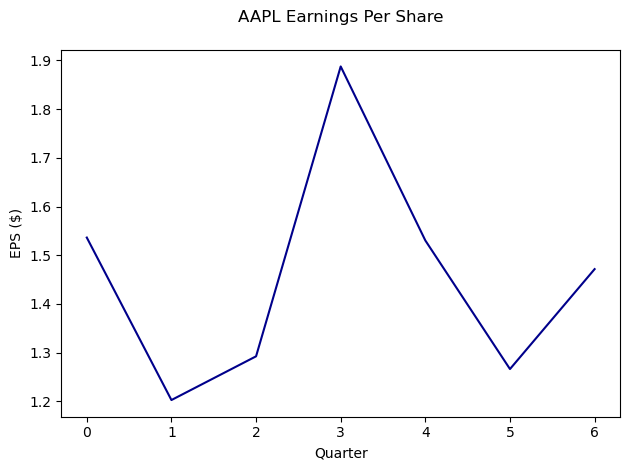

In [7]:
ax = income_pivot['eps'].dropna().plot(color='darkblue')
ax.set_title(f'{ticker} Earnings Per Share', pad=20)
ax.set_xlabel('Quarter')
ax.set_ylabel('EPS ($)')
plt.tight_layout()

print("EPS Evaluation:")
print("- Upward trend suggests growing profitability")
print("- Volatility may indicate inconsistent earnings")
plt.show()

Revenue Growth Assessment:
Positive bars = Revenue expansion
Negative bars = Revenue contraction
Look for consistent growth patterns


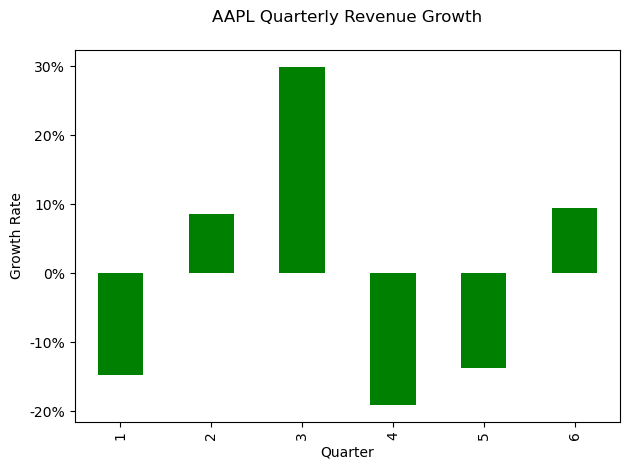

In [8]:
ax = income_pivot['revenue_growth'].dropna().plot(kind='bar', color='green')
ax.set_title(f'{ticker} Quarterly Revenue Growth', pad=20)
ax.set_xlabel('Quarter')
ax.set_ylabel('Growth Rate')
ax.yaxis.set_major_formatter('{x:.0%}')
plt.tight_layout()

print("Revenue Growth Assessment:")
print("Positive bars = Revenue expansion")
print("Negative bars = Revenue contraction")
print("Look for consistent growth patterns")
plt.show()

## Summary 

This chapter demonstrates how to analyze a company's income statement using Python to extract key insights about profitability and growth. We retrieve financial data via the Tiingo API, then calculate and visualize three essential metrics: profit margins (gross, operating, and net) to assess cost efficiency, earnings per share (EPS) to evaluate shareholder profitability, and revenue growth to gauge business expansion. The analysis includes clear interpretation guidelines, showing how to identify positive trends and warning signs in each metric. Through visualizations and a practical decision framework, we transform raw financial data into actionable investment insights, culminating in a snapshot of the company's latest quarterly performance. The approach balances technical data analysis with real-world business context for meaningful financial evaluation.